In [1]:
import bz2
import json
from tqdm import tqdm

responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:04, 3118.03it/s]


In [2]:
import pandas as pd
import numpy as np

df = pd.DataFrame(data=[pd.Series(responses[i]).values for i in range(len(responses))], columns=pd.Series(responses[0]).index.values)

In [4]:
# На самом деле основной проблемой явялется то, что одни и те же города могут быть записаны по-разному (не просто г. Москва, а, например, г. Москва, "Китай-город"), это ведет к неточности. Чтобы избежаьть этого необходимо пропустить названия городов через регулярку, скорее всего кастомную
df[['city', 'bank_name']].value_counts()

city                                 bank_name                
г. Москва                            Сбербанк России              8146
                                     Альфа-Банк                   3871
                                     Русский Стандарт             2801
                                     ВТБ 24                       2714
г. Санкт-Петербург                   Сбербанк России              2434
                                                                  ... 
г. Москва,  Отделение "Жулебинское"  Московский Кредитный Банк       1
г. Москва, "Китай-город"             Фора-Банк                       1
г. Москва, Ветошный пер              Восточный Экспресс Банк         1
г. Москва, Видное                    Сбербанк России                 1
г. … или другой населенный пункт     Лето Банк                       1
Length: 18769, dtype: int64

In [3]:
import re
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [6]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [7]:
feedback_on_words = []
feedback_on_symbols = []

for feedback in df['text']:
    s = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@^_`{|}~]',  ' ',feedback)
    s = word_tokenize(s.lower())
    len_in_symb = 0
    for word in s: len_in_symb += len(word)
    feedback_on_words.append(len(s))
    feedback_on_symbols.append(len_in_symb)

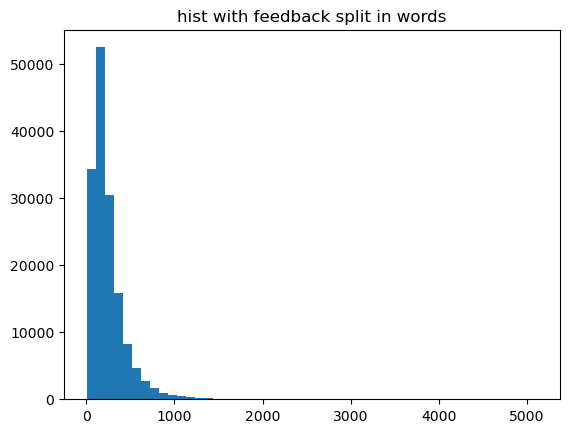

In [8]:
plt.hist(feedback_on_words, bins=50)
plt.title(label='hist with feedback split in words')
plt.xlabel = 'length of feedbacks in words'
plt.ylabel = 'count'
plt.show()

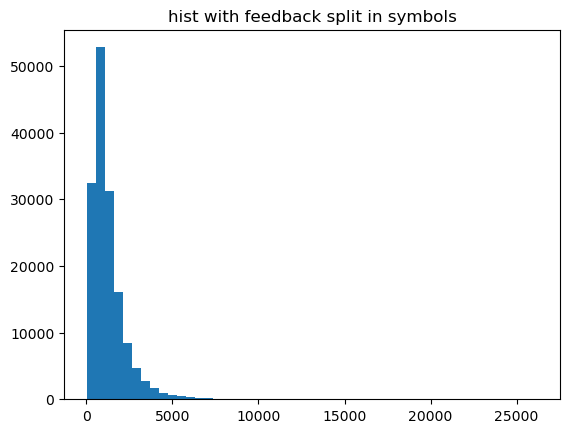

In [9]:
plt.hist(sorted(feedback_on_symbols), bins=50)
plt.title(label='hist with feedback split in symbols')
plt.xlabel = 'length of feedbacks in symbols'
plt.ylabel = 'count'
plt.show()

Как видно из полученных графиков полуенные гистограммы довольно схожи, это логично, ведь в среднем чем больше слов в предложении, тем больше в нем символов.  

In [10]:
from collections import Counter

all_words = []
for feedback in df['text']:
    s = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@^_`{|}~]',  ' ',feedback)
    all_words += word_tokenize(s.lower())

In [11]:
counter_ = Counter(all_words)

In [12]:
counter_.most_common(10)

[('в', 1330069),
 ('и', 1058651),
 ('не', 852394),
 ('на', 707750),
 ('что', 639972),
 ('я', 577384),
 ('с', 462212),
 ('по', 372707),
 ('мне', 320932),
 ('банка', 275642)]

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pavel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from nltk.corpus import stopwords
stopwords_ = stopwords.words('russian')

In [15]:
without_stop_words = [word for word in all_words if word not in stopwords_ and len(word) > 2]

counter_without_stop_words = Counter(without_stop_words)

In [16]:
counter_without_stop_words.most_common(10)

[('банка', 275642),
 ('банк', 215087),
 ('это', 183339),
 ('деньги', 131124),
 ('карту', 105768),
 ('карты', 101745),
 ('кредит', 81080),
 ('день', 76511),
 ('банке', 72038),
 ('заявление', 70392)]

In [6]:
from pymorphy2.analyzer import MorphAnalyzer

analyzer = MorphAnalyzer()

In [33]:
#Для ускорения процесса используем первые 100000 слов
analyzed = []
i = 0
for token in without_stop_words:
    analyzed.append(analyzer.parse(token)[0])
    i += 1
    if i == 100000:
        break

lemmas = [token.normal_form for token in analyzed]

In [34]:
lemmas_counter = Counter(lemmas)

In [35]:
# не уверен, что начальная форма слова "деньги" - это "деньга" ) но пусть будет так
lemmas_counter.most_common(10)

[('банк', 3357),
 ('карта', 1390),
 ('это', 864),
 ('кредит', 816),
 ('мой', 808),
 ('вклад', 739),
 ('который', 716),
 ('деньга', 710),
 ('день', 667),
 ('клиент', 646)]

In [36]:
nouns = [noun for noun in lemmas if 'NOUN' in  analyzer.parse(noun)[0].tag]

In [37]:
nouns_counter = Counter(nouns)
nouns_counter.most_common(10)

[('банк', 3357),
 ('карта', 1390),
 ('кредит', 816),
 ('вклад', 739),
 ('деньга', 710),
 ('день', 667),
 ('клиент', 646),
 ('сотрудник', 589),
 ('сумма', 566),
 ('счёт', 556)]

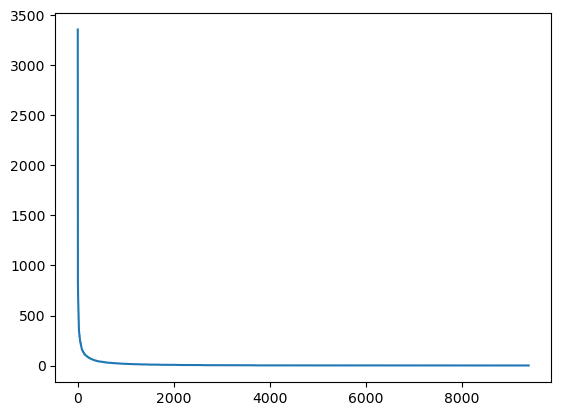

In [47]:
x = []
for key in lemmas_counter.keys():
    x.append(lemmas_counter.get(key))    

x = sorted(x, reverse=True)

plt.plot(x)
plt.show()

Наблюдается достаточно быстрое уменьшение частоты в зависимости от порядкового номера слова, что говорит о соблюдении закона Ципфа, хотя видно что сначала идет резкое снижение, а потом такое же резкое выравнивание.
Возможно это связано с тем, что были убраны стоп слова.

In [49]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = word_tokenize(row['text'])
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(cnt.values()))

100%|██████████| 153499/153499 [17:38<00:00, 145.07it/s]


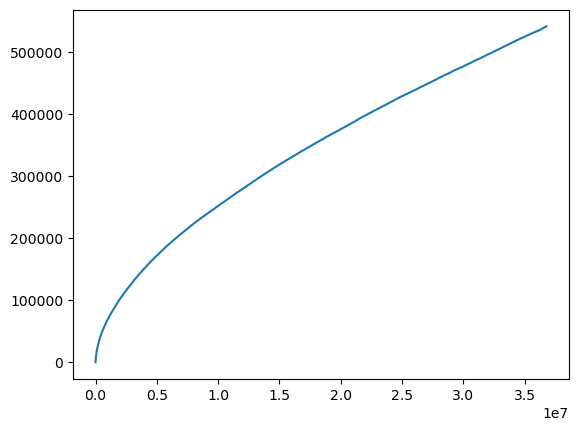

In [50]:
plt.plot(n_tokens, n_words)
plt.show()

In [52]:
nouns_counter.get('сотрудник'), nouns_counter.get('клиент')
# Как видно из полученных значений для первых 100000 слов клиент встречается чаще

(589, 646)

In [53]:
nouns_counter.get('мошенничество'), nouns_counter.get('доверие')

(16, 27)

In [137]:
max_positive_comments = df[df['rating_grade'] == 5]['text']
max_negative_comments = df[df['rating_grade'] == 1]['text']

In [7]:
def super_parser(feedbacks):
    return [[word for word in word_tokenize(re.sub(r'[!"#$%&\'()*+,./:;<=>?@^_`{|}~]',  ' ',feedback).lower()) if word not in stopwords_ and len(word) > 2 ] for feedback in feedbacks.values]

In [239]:
new_pos_feedbacks = super_parser(max_positive_comments)
new_neg_feedbacks = super_parser(max_negative_comments)

In [244]:
all_words_pos = set([word for comment in new_pos_feedbacks for word in comment])
all_words_neg = set([word for comment in new_neg_feedbacks for word in comment])

In [245]:
def TF(word, comment):
    return comment.count(word) / len(comment)

In [251]:
import math

def IDF(word, corpus):
    count = 0
    for commnet in corpus:
        if word in commnet:
            count += 1
    return math.log(len(corpus) / count) if count > 0 else math.inf

In [260]:
metrics_calculator_for_positive = {}
i = 0
for word in all_words_pos:
    idf = IDF(word, new_pos_feedbacks)
    all_tfs = np.array([TF(word, comment) for comment in new_pos_feedbacks])
    metrics_calculator_for_positive[word] = (all_tfs, idf)
    i += 1
    if i == 10000: break

In [267]:
sort_pos = sorted(metrics_calculator_for_positive.items(), key=lambda item: item[1][1])
for i in range(len(sort_pos)):
    print(sort_pos[i][0], sum(sort_pos[i][1][0]), sort_pos[i][1][1])

счет 30.827635978807873 1.7557802839485477
банков 21.67567097900362 1.8037250148814212
карта 23.708229019960367 1.861490541675166
других 18.062669945221128 1.9802031741175623
мои 16.44822249507723 2.0255281525289366
получить 13.712676892685948 2.2087774966169063
хотелось 13.251923837106492 2.2953389298419147
администратора 11.581874648654884 2.3790433040014145
человек 11.497991474556262 2.39457041816632
клиентам 11.880253614431593 2.4687930363505486
вопросов 10.060731827652898 2.5325827742258786
услугами 11.395760968341149 2.536869107406564
кстати 8.929944621892789 2.562098805782444
кредитной 10.73013650293335 2.562098805782444
открыть 11.18768535253013 2.5656292595818266
думаю 8.889095578449492 2.566513823991561
ещё 10.717069937576289 2.671874339649387
раза 8.791122717373597 2.686733454053137
мое 7.529482252226538 2.706895427343481
подробно 8.94030854452002 2.71097706566313
предложили 8.653549182036537 2.7253954410874015
такого 6.768114788382447 2.8165648282256948
сама 6.9045296008176

Для расчета метрики TF-IDF были написаны небольшие функции, из общей выборки слов было взято только 10000 экземпляров (понимаю, результат получится далеко не точным, но время обработки очень долгое). Далее для каждого слова были посчитаны метркии TF и IDF (решил посчитать отдельно потому, что не совсем понимаю, как можно точно оценить важность слова с помощью данной метрики). Далее упорядочил слова по метрике IDF, чтобы понимать, в скольких отзывах есть проверяемое слово. Также вывел сумму TF (так как это массив, длина которого равна количеству анализируемых отзывов), чтобы понимать насколько часто вообще слово встречается в отзывах.

Для самых отрицательных решил не расписовать, так как алгоритм тот же.

In [8]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [159]:
# Выберем первые 1000 отзывов, так как при 153500 отзывов не хватает оперативки и обработка 1000 отзывов не такая долгая
'''feedbacks = super_parser(df.text[:1000])
new_feedbacks = []
for comment in feedbacks:
    temp = []
    for word in comment:
        temp.append(analyzer.parse(word)[0].normal_form)
    new_feedbacks.append(temp)'''

feedbacks = []
for feedback in df.text[:1000]:
    temp = []
    for word in word_tokenize(feedback):
        if word not in stopwords_ and len(word) > 2:
            temp.append(analyzer.parse(word)[0].normal_form.lower())
    feedbacks.append(temp)
    
dictionary = Dictionary(feedbacks)
corpus = [dictionary.doc2bow(feedback) for feedback in feedbacks]

In [160]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [161]:
index = similarities.MatrixSimilarity(corpus_tfidf)
sim = index[corpus_tfidf]

In [162]:
import seaborn as sns

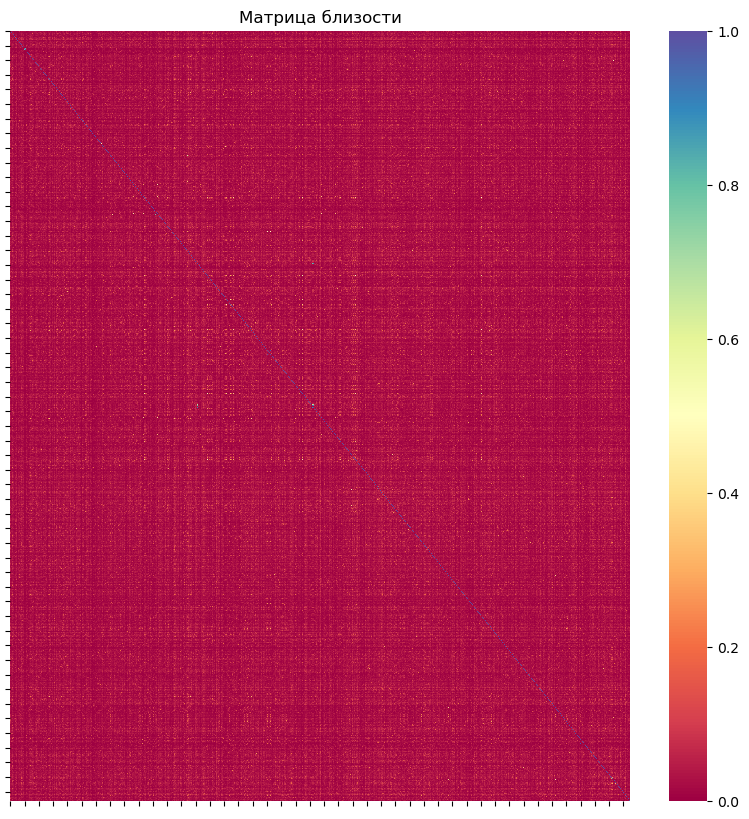

In [163]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sim, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости")
plt.show()

Как видно получилась тепловая карта, на которой совершенно ничего не понятно, поэтому попробуем снизить размерность

In [164]:
from gensim.models import lsimodel

lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=5)

In [165]:
lsi.show_topics(5)

[(0,
  '-0.184*"карта" + -0.153*"вклад" + -0.141*"кредит" + -0.108*"деньга" + -0.105*"счёт" + -0.101*"сумма" + -0.095*"мой" + -0.093*"сотрудник" + -0.093*"договор" + -0.090*"отделение"'),
 (1,
  '-0.565*"вклад" + -0.296*"ставка" + -0.259*"пополнение" + -0.205*"условие" + -0.124*"односторонний" + -0.117*"изменение" + -0.116*"вкладчик" + -0.114*"договор" + 0.108*"кредит" + 0.101*"звонок"'),
 (2,
  '-0.242*"звонок" + 0.238*"карта" + -0.206*"номер" + -0.166*"телефон" + -0.161*"ваш" + -0.152*"согласие" + -0.151*"данные" + -0.144*"персональный" + -0.135*"удалить" + -0.131*"прекратить"'),
 (3,
  '0.421*"страховка" + 0.370*"страхование" + 0.327*"кредит" + -0.195*"карта" + 0.156*"договор" + -0.132*"банкомат" + 0.117*"отказаться" + -0.108*"номер" + 0.107*"досрочный" + 0.103*"отказ"'),
 (4,
  '-0.218*"задолженность" + -0.185*"платёж" + -0.172*"сумма" + -0.162*"средство" + -0.146*"погашение" + -0.134*"денежный" + 0.130*"офис" + -0.120*"комиссия" + 0.117*"очередь" + -0.114*"кредитный"')]

In [166]:
corpus_lsi = lsi[corpus]
index = similarities.MatrixSimilarity(corpus_lsi)
sim = index[corpus_lsi]

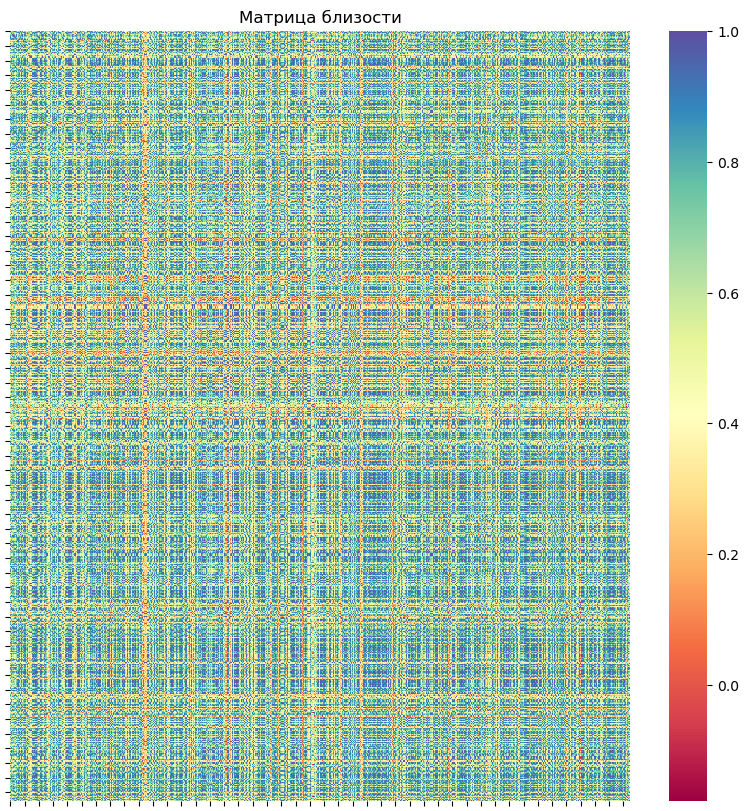

In [167]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sim, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости")
plt.show()

In [168]:
sim = (sim + 1) / 2

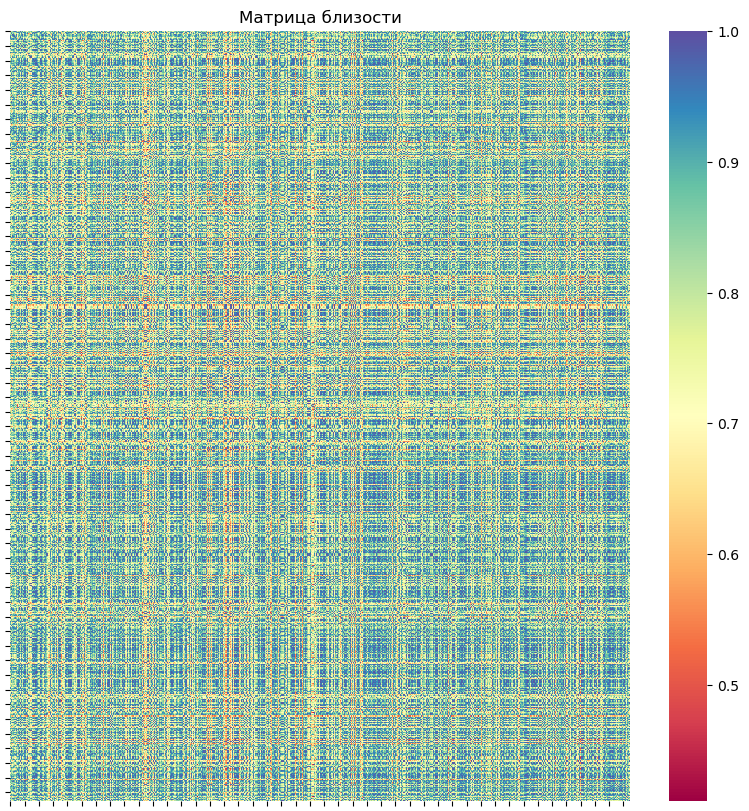

In [169]:
plt.figure(figsize = (10,10))
sns.heatmap(data=sim, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title("Матрица близости")
plt.show()

К сожалению ни построение другой модели, ни ее уменьшение размерности картину не исправили. Увеличение количества тем также ничего не изсменило

In [170]:
X = [0] * 1000
Y = [0] * 1000
for i in range(1000):
    vec = corpus[i]
    LSI_topics = (lsi[vec])
    for topic in LSI_topics:
        if topic[0] == 0:
            X[i] = topic[1]
        elif topic[0] == 3:
            Y[i] = topic[1]

In [171]:
topics =  df['bank_name'][:1000]
for i in range(1000):
    if 'ВТБ' not in topics.iloc[i] and topics.iloc[i] != 'Сбербанк России':
        topics.iloc[i] = 'Другой банк'
    elif 'ВТБ' in topics.iloc[i]:
        topics.iloc[i] = 'ВТБ'

In [172]:
sorted(set(topics.values))

['ВТБ', 'Другой банк', 'Сбербанк России']

In [173]:
vis_df = pd.DataFrame({'X': X, 'Y': Y, 'topic' : topics})

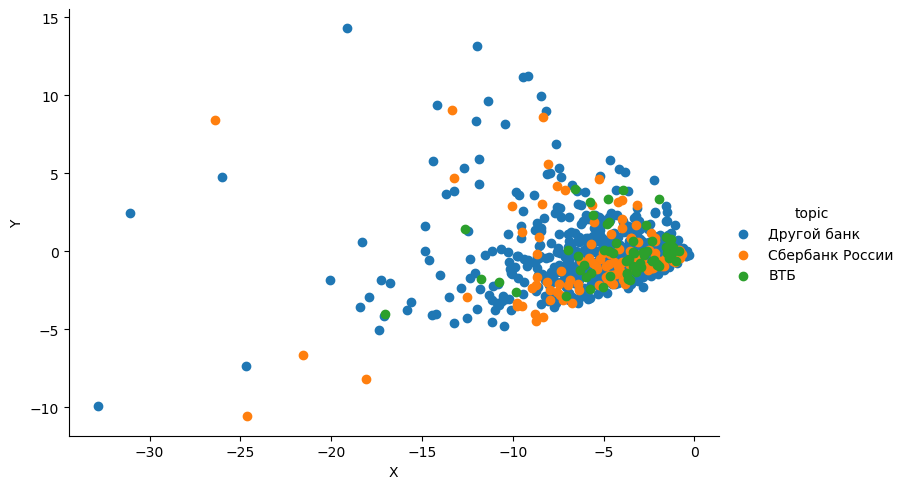

In [174]:
sns.FacetGrid(vis_df, hue="topic", height=5, aspect=1.5).map(plt.scatter, "X", "Y").add_legend()

In [114]:
from sklearn.model_selection import train_test_split

data = df[(df['rating_grade'] == 1) | (df['rating_grade'] == 5)]
x_train, x_test, y_train, y_test = train_test_split(data['text'], data['rating_grade'])

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [119]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)

In [123]:
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [124]:
from sklearn.metrics import classification_report
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.98      0.97      0.98     11994
         5.0       0.92      0.94      0.93      3531

    accuracy                           0.97     15525
   macro avg       0.95      0.96      0.95     15525
weighted avg       0.97      0.97      0.97     15525



Получились довольно высокие результаты, попробуем улучшить их с помощью триграмм

In [175]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.99      0.88      0.93     13439
         5.0       0.55      0.96      0.70      2086

    accuracy                           0.89     15525
   macro avg       0.77      0.92      0.81     15525
weighted avg       0.93      0.89      0.90     15525



Преобразовав единичные слова в триграммы результат силь но ухудшился



In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [177]:
vec = TfidfVectorizer()
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

         1.0       0.99      0.96      0.98     12254
         5.0       0.87      0.97      0.92      3271

    accuracy                           0.96     15525
   macro avg       0.93      0.97      0.95     15525
weighted avg       0.97      0.96      0.97     15525



В результате самый высокий результат показал countervectorizer, создавая bow из слов, чуть хуже результаты показала модели, где вместо кодирования использовались значения tfidf, и самый низкий результат показал bow из триграмм